<a href="https://colab.research.google.com/github/MrSupiri/lazy-koala/blob/proof-of-concept/Lazy_Koala_POC_with_prod_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lazy Koala - Proof of concept

To prove my norval approach detecting anomalies in time series dataset I first need to

1.   Create time series dataset
2.   Insert anomalies to the dataset and create labels
3.   Run it againest a traditional anomaly detection algorithms (ML)
4.   Run it againest a RNN (current standard)
5.   Run is againest a CNN (norval approach)
6.   Show proofs CNN is better atleast in one metric so it's viable approach



## Create time series dataset

There 2 main requirements when creating the time series dataset.
1. It need to complex enough so that using ML/DL make sense
2. There should be pattern, Models won't able to find anomalies in completly random distributions becouse every data point is anomaly.

So to do this I am gonna take sin curve and introduce a random fluctuation. Sin funcation introduce a pattern to the dataset while the random fluctuation make it so it's not very easy understand the pattern.

In [1]:
import numpy as np
import matplotlib.pyplot as plot
import pandas as pd

df = pd.read_json('https://storage.googleapis.com/static.isala.me/lazy-koala/memory_used_bytes.json')

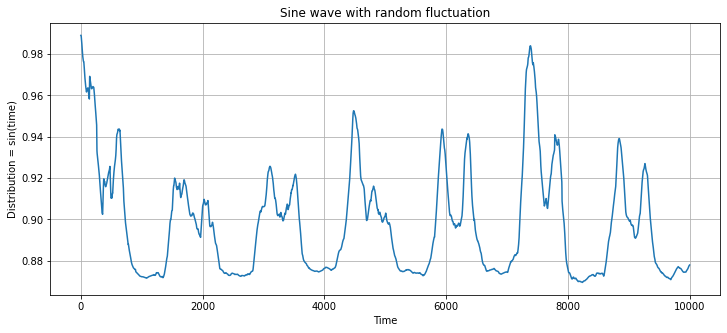

In [2]:
df['value_sma'] = df.value.rolling(120, min_periods=1).mean()


distribution = df['value_sma'] / np.max(df['value_sma'])

distribution = distribution.tolist()

# Plot a sine wave using time and amplitude obtained for the sine wave
plot.figure(figsize=(12, 5))
plot.plot(range(10000), distribution[:10000])
# Give a title for the sine wave plot
plot.title('Sine wave with random fluctuation')
# Give x axis label for the sine wave plot
plot.xlabel('Time')
# Give y axis label for the sine wave plot
plot.ylabel('Distribution = sin(time)')
plot.grid(True, which='both')
# plot.axhline(y=0, color='k')
plot.show()


## Insert anomalies to the dataset and create labels

requirements:
1. We should be able to create random anomalies which spans for multiple timestamps
2. We should be able to recoard these anomalies so we can train a model to detect them

In [3]:
# import random

# def create_anomaly(series, start, end):
#     start = start * 10
#     end = min(len(series), end * 10)
#     if end > start:
#         random_distribution = np.random.uniform(-1, 1, end-start)
#         series[start:end] = random_distribution
#     return series

# i = 0
# anomalies = []
# anomaly_distribution = distribution.copy()

# while i < len(distribution):
#     size = random.randint(1,3)
#     if random.randint(0,10) == 5:
#         anomaly_distribution = create_anomaly(anomaly_distribution, i, i+size)
#         i += size
#         anomalies += [True] * size
#     else:
#         i +=1
#         anomalies.append(False)

# plot.plot(time, anomaly_distribution)
# # Give a title for the sine wave plot
# plot.title('distribution with a random anomaly')
# # Give x axis label for the sine wave plot
# plot.xlabel('Time')
# # Give y axis label for the sine wave plot
# plot.ylabel('Distribution = sin(time)')
# plot.grid(True, which='both')
# plot.axhline(y=0, color='k')
# plot.show()
# # Display the sine wave
# for k in range(0, len(anomalies), 10):
#     print(anomalies[k:k+10])

# Model to prove the concept

My project revolves around a concept of anomaly detection by predicting expected future and compare with reality.

### Predict the future
To predict the future from past data (AKA do regression) I came up with a standard multilayer perceptron (MLP) with a bottlneck layer in the middle. Becouse there is bottleneck layer in the middle, model has to figure out a deeper meaning behind the data so it can successfully produced the expected output.

This Model is silghtly modified version of AutoEncoder.

This Model take the 48 data points time series as the `INPUT` and next 10 data points as the `OUTPUT`.

So it's job is to given the past 48 data points predict the next 10 data points.


In [4]:
import keras
from keras import layers

input = keras.Input(shape=(128,))
encoded = layers.Dense(64, activation='relu')(input)
encoded = layers.Dense(32, activation='relu')(encoded)
encoded = layers.Dense(32, activation='relu')(encoded)
encoded = layers.Dense(16, activation='relu')(encoded)
decoded = layers.Dense(8, activation='relu')(encoded)
decoded = layers.Dense(16, activation='linear')(decoded)

autoencoder = keras.Model(input, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 16)                144   

# Create the Inputs and Outputs

On the first setup in this notebook, I took a sine wave and added bit of noise to it so it's can not be modeled very easily.

So Now we need to take that time series data sets and chunk them into `INPUTS` and `OUTPUTS`.

To do that, I put all the values from the noisy sine wave to list and iterated over it. 

While iterating,
- I took the current index of the list and add 48 to it.
- Then used those 2 values to create a sublist and added to `INPUTS`
- Then I took the 10 data points after those values and added to `OUTPUTS`
- Then I repeated the whole processes till either the sub list `INPUT` or `OUTPUT` doesn't satisfy required input or output size.

Then did few preprocessing to make sure data is in right shape so the model can parse it.

In [5]:
from sklearn import preprocessing

X = []
Y = []

batch_size = 128
predict_size = 16

for i in range(len(distribution)):
    _x = distribution[i:i+batch_size]
    _y = distribution[i+batch_size:i+batch_size+predict_size]
    if len(_y) < predict_size or len(_x) < batch_size:
        break
    X.append(np.array(_x).astype('float32'))
    Y.append(np.array(_y).astype('float32'))

X = np.array(X).reshape([-1, batch_size])
Y = np.array(Y).reshape([-1, predict_size])

print(X.shape)
print(Y.shape)

(43044, 128)
(43044, 16)


# Training

After I had the `INPUTS` and `OUTPUTS`. I used scikit learn's `train_test_split` function to split the data by 8:2 for training and testing

Then I trained the model with those data for 20 rounds

Important note: Becouse I am using sequence dataset, I kept shuffling off so the model will try to adapt to patterns between outside of the INPUTs and OUTPUTs

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

history = autoencoder.fit(X_train, y_train,
                epochs=10,
                shuffle=False,   
                validation_data=(X_test, y_test))

Epoch 1/10
1077/1077 [==============================] - 19s 3ms/step - loss: 0.1507 - val_loss: 4.8652e-04
Epoch 2/10
1077/1077 [==============================] - 3s 2ms/step - loss: 8.2805e-04 - val_loss: 5.1404e-04
Epoch 3/10
1077/1077 [==============================] - 3s 2ms/step - loss: 8.7011e-04 - val_loss: 5.0948e-04
Epoch 4/10
1077/1077 [==============================] - 2s 2ms/step - loss: 7.0261e-04 - val_loss: 4.9509e-04
Epoch 5/10
1077/1077 [==============================] - 3s 2ms/step - loss: 6.1471e-04 - val_loss: 5.4134e-04
Epoch 6/10
1077/1077 [==============================] - 3s 2ms/step - loss: 5.3986e-04 - val_loss: 5.3422e-04
Epoch 7/10
1077/1077 [==============================] - 3s 2ms/step - loss: 5.0923e-04 - val_loss: 5.7007e-04
Epoch 8/10
1077/1077 [==============================] - 3s 2ms/step - loss: 4.6728e-04 - val_loss: 6.1573e-04
Epoch 9/10
1077/1077 [==============================] - 2s 2ms/step - loss: 4.3700e-04 - val_loss: 6.8446e-04
Epoch 10/10
1

# Testing

From here out I am doing few testing to see if Model is performing all right

## Compare the Model's output the the real data

Note - Here I am testing the model with it's training data which isn't good but for POC this won't be that bad

In [7]:
testing_sample = 1

prediction = autoencoder.predict(np.array(X[testing_sample-1]).reshape([1, batch_size]))

print("Model's output for 50th data point: \t", list(prediction[0]))
print("Ground truth for the 50th data point: \t", list(Y[testing_sample-1]))

Model's output for 50th data point: 	 [0.8962621, 0.901713, 0.89738655, 0.9070101, 0.89519584, 0.8979785, 0.9029994, 0.90416694, 0.89628834, 0.90576905, 0.8944269, 0.89280653, 0.9039774, 0.8996929, 0.90539294, 0.9026229]
Ground truth for the 50th data point: 	 [0.9604926, 0.96018666, 0.9598933, 0.95970154, 0.9595095, 0.9593181, 0.95914906, 0.95890504, 0.9586729, 0.958441, 0.95829475, 0.9582585, 0.9613889, 0.9637257, 0.9657626, 0.9677999]


### Testing if the predictions matches the sine wave 

Here, <br>
Blue Line - Input data <br>
Green Line - Expected output (ground truth) <br>
Orange Line - Model's prediction

In [8]:
x_scale = (0.5, 1.1)

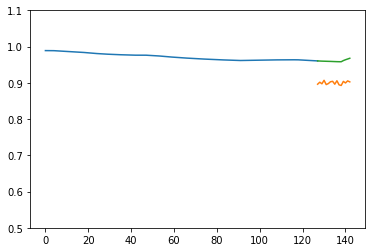

In [9]:
plot.plot(range(batch_size), X[testing_sample])
plot.plot(range(batch_size-1,batch_size+predict_size-1), prediction[0])
plot.plot(range(batch_size-1,batch_size+predict_size-1), Y[testing_sample-1])
plot.ylim(x_scale[0], x_scale[1])
plot.show()

### Testing if the model can recreate the entrie sine wave from it's own

#### Testing Setup
- TBD

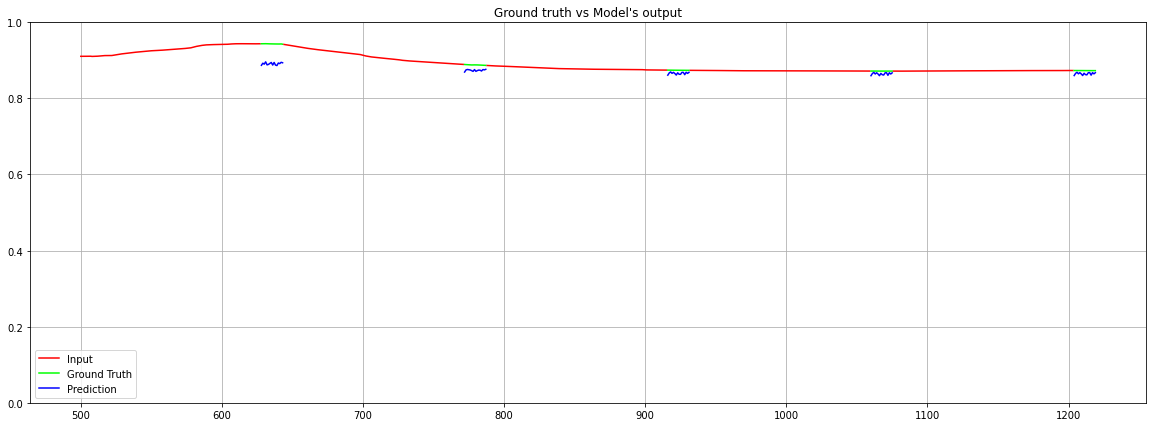

In [12]:
plot.figure(figsize=(20, 7))

starting_point = 500
output_size = 16
steps = 5
batch_size = 128
output_start = 0
output_end = starting_point

while output_end < starting_point+(batch_size*steps):
    input_start = output_end
    input_end = output_end+batch_size
    
    input_chunk = distribution[input_start:input_end]
    plot.plot(range(input_start, input_end), input_chunk, color="#FF0000")

    output_start = output_end+batch_size
    output_end = output_start+output_size

    output_chunk = distribution[output_start:output_end]
    plot.plot(range(output_start, output_end), output_chunk, color="#00FF00")

    prediction = autoencoder.predict(np.array(input_chunk).astype('float32').reshape([1, batch_size]))[0]
    plot.plot(range(output_start, output_end), prediction , color="#0000FF")

plot.title("Ground truth vs Model's output")
plot.legend(['Input', 'Ground Truth', 'Prediction'])
plot.grid(True, which='both')
plot.ylim(0, 1)
plot.show()